# DH - Data Science - Grupo 6.

Integrantes:

*    José Roberto Canales Delgado
*    Matías Sala
*    Luciana Sande
*    Bianca Somadossi
*    Tomás Guzmán Camacho


# Desafío 1: Análisis exploratorio de un dataset de precios de propiedades.

Objetivo: desarrollar un modelo de regresión que permita predecir el precio por metro cuadrado de una propiedad.

## 1. Entorno de implementación.

### 1.1 Setup inicial.

In [382]:
# initial setup
%run "common/0_notebooks_base_setup.py"

C:\Users\Lu\Lu\Digital House\grupo_6\DH_grupo_6common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<Figure size 432x288 with 0 Axes>

In [383]:
#importamos de todas las librerías que vamos a utilizar

import numpy as np
import pandas as pd
import re
import geopandas as gpd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
# import shapely 
# import descartes 
# import pyproj 
# import unicodedata
# import squarify
# import pygal
from scipy.stats import iqr

%matplotlib inline


Descripción de las librerías y módulos importados:

* NumPy: es una librería de Python (“Numerical Python”), especializada en el cálculo numérico y el análisis de datos. Proporciona potentes estructuras de datos, implementando matrices y matrices multidimensionales.
* Pandas: 
* Re: Este módulo proporciona operaciones de coincidencia de expresiones regulares
* Geopandas:
* Seaborn:
* Missingno: es una librería de Pÿthon, compatible con Pandas, que ofrece una buena y simple forma de visualizar la distribución de valores Nan (Not a Number)
* Matplotlib: es una biblioteca para la generación de gráficos a partir de datos contenidos en listas o arrays de Python y su extensión matemática NumPy.

In [384]:
pd.options.display.float_format='{:,.2f}'.format

## 2. Procesamiento de los datos.


### 2.1. Importación del dataset.

In [385]:
#Importatemos el dataset original de Properatti, creando un Dataframe.

data_location = "Data/properatti.csv"

original_data = pd.read_csv(data_location, sep=",", encoding="UTF-8")


### 2.2 Exploración del dataset.

Exploramos el data set, obteniendo un primer acercamiento de sus métricas:

In [386]:
#Mostramos la composición de filas y columnas del dataset, en forma de tupla (filas,columnas).

original_data.shape


(121220, 26)

In [387]:
# A continuación, veremos cu+ales son las columnas que presenta:
    
original_data.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [388]:
#Mostramos los primeros 5 registros del data set:

original_data.head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"3,430,787.00","-34.6618237,-58.5088387",-34.66,...,40.00,"1,127.27","1,550.00",nan,nan,nan,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,"3,432,039.00","-34.9038831,-57.9643295",-34.90,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"3,430,787.00","-34.6522615,-58.5229825",-34.65,...,55.00,"1,309.09","1,309.09",nan,nan,nan,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,"3,431,333.00","-34.6477969,-58.5164244",-34.65,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,"3,435,548.00","-38.0026256,-57.5494468",-38.00,...,35.00,"1,828.57","1,828.57",nan,nan,nan,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [389]:
# Presentamos un resumen conciso de la estructura del dataset, incluyendo el tipo de datos de cada columna, cantidad de valores no nulos y el uso de memoria:

original_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

In [390]:
#Generamos estadísticas descriptivas del dataset. Las estadísticas descriptivas incluyen aquellas que resumen la
#tendencia central, la dispersión y la forma de la distribución de un conjunto de datos, excluyendo valores NaN.

original_data.describe()


,Unnamed: 0,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,"121,220.00","102,503.00","69,670.00","69,670.00","100,810.00","100,810.00","100,810.00","81,892.00","101,313.00","68,617.00","87,658.00","7,899.00","47,390.00","14,262.00"
mean,"60,609.50","3,574,442.32",-34.63,-59.27,"468,525.93","4,229,396.83","239,700.58",233.80,133.05,"2,160.09","6,912.22",17.45,3.08,"5,009.23"
std,"34,993.34","354,130.62",1.98,2.30,"2,260,100.59","6,904,714.13","391,323.88","1,782.22",724.35,"2,759.29","28,378.64",120.24,1.86,"120,440.26"
min,0.00,"3,427,208.00",-54.82,-75.68,0.00,0.00,0.00,0.00,0.00,0.60,1.51,1.00,1.00,1.00
25%,"30,304.75","3,430,234.00",-34.67,-58.73,"110,000.00","1,583,309.44","89,733.88",50.00,45.00,"1,218.18","1,550.00",1.00,2.00,"1,000.00"
50%,"60,609.50","3,433,910.00",-34.60,-58.48,"185,000.00","2,558,452.50","145,000.00",84.00,75.00,"1,800.00","2,213.11",3.00,3.00,"2,000.00"
75%,"90,914.25","3,836,668.00",-34.44,-58.40,"420,000.00","4,675,792.50","265,000.00",200.00,150.00,"2,486.41","3,355.55",6.00,4.00,"4,000.00"
max,"121,219.00","6,948,895.00",4.55,-53.73,"650,000,000.00","821,271,104.30","46,545,445.00","200,000.00","187,000.00","206,333.33","3,999,999.96","3,150.00",32.00,"10,001,500.00"


#### 2.2.1. Analizamos proporción de valores NaN del dataset.

In [391]:
#Definimos una función que nos calcule el porcentaje de valores nulos para poder reutilizarla.

def get_null(df):
    missing_values_sum = df.isnull().sum()
    missing_values_percent = df.isnull().mean()*100
    return missing_values_percent


In [392]:
porcentaje_nulos = get_null(original_data)
porcentaje_nulos

Unnamed: 0                    0.00
operation                     0.00
property_type                 0.00
place_name                    0.02
place_with_parent_names       0.00
country_name                  0.00
state_name                    0.00
geonames_id                  15.44
lat-lon                      42.53
lat                          42.53
lon                          42.53
price                        16.84
currency                     16.84
price_aprox_local_currency   16.84
price_aprox_usd              16.84
surface_total_in_m2          32.44
surface_covered_in_m2        16.42
price_usd_per_m2             43.39
price_per_m2                 27.69
floor                        93.48
rooms                        60.91
expenses                     88.23
properati_url                 0.00
description                   0.00
title                         0.00
image_thumbnail               2.57
dtype: float64

<AxesSubplot:>

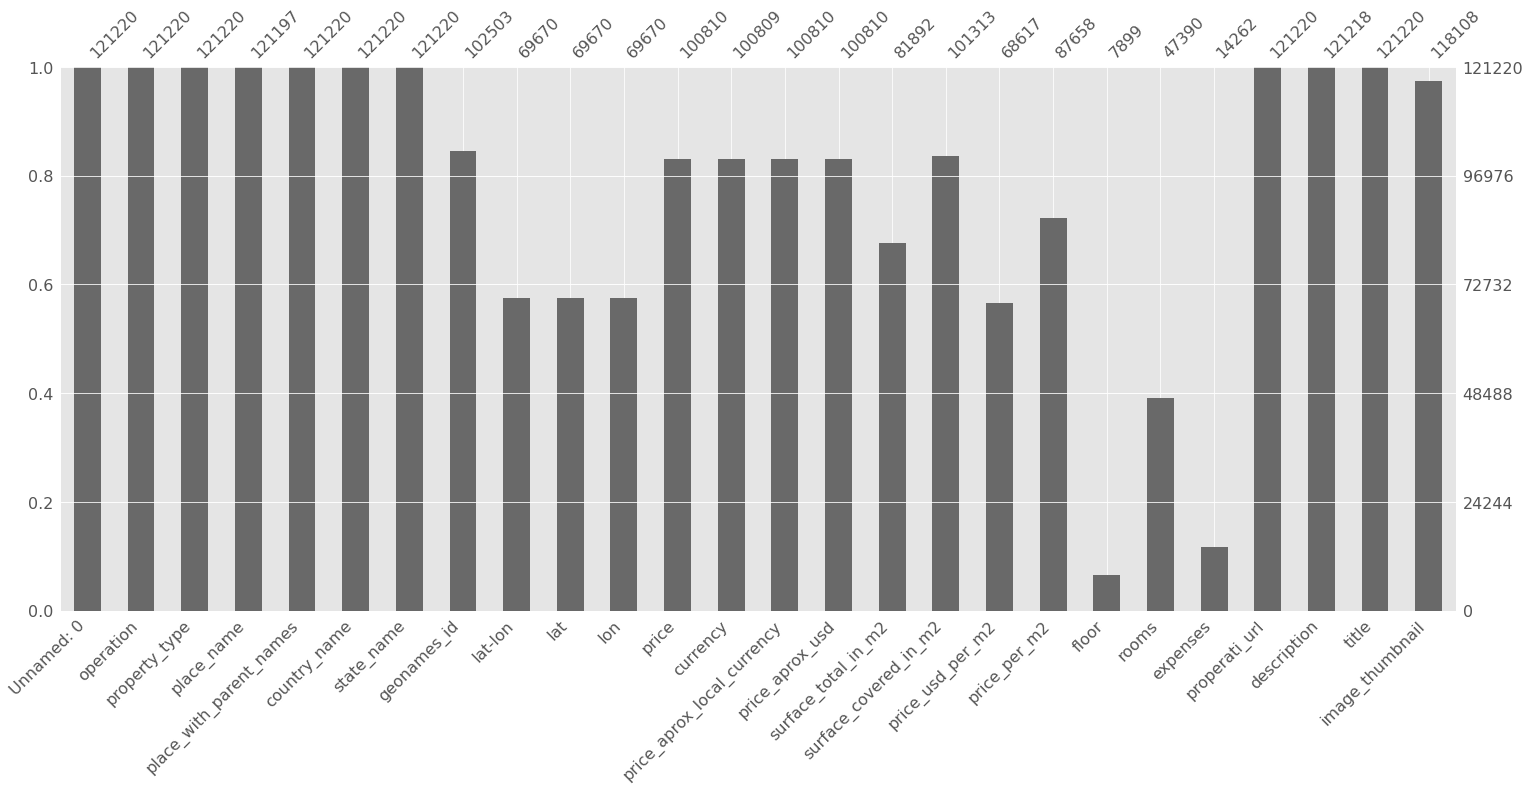

In [393]:
#Graficamos de forma comparativa la densidad de datos de cada columna, utilizando un gráfico de barras.

msno.bar(original_data)

<AxesSubplot:>

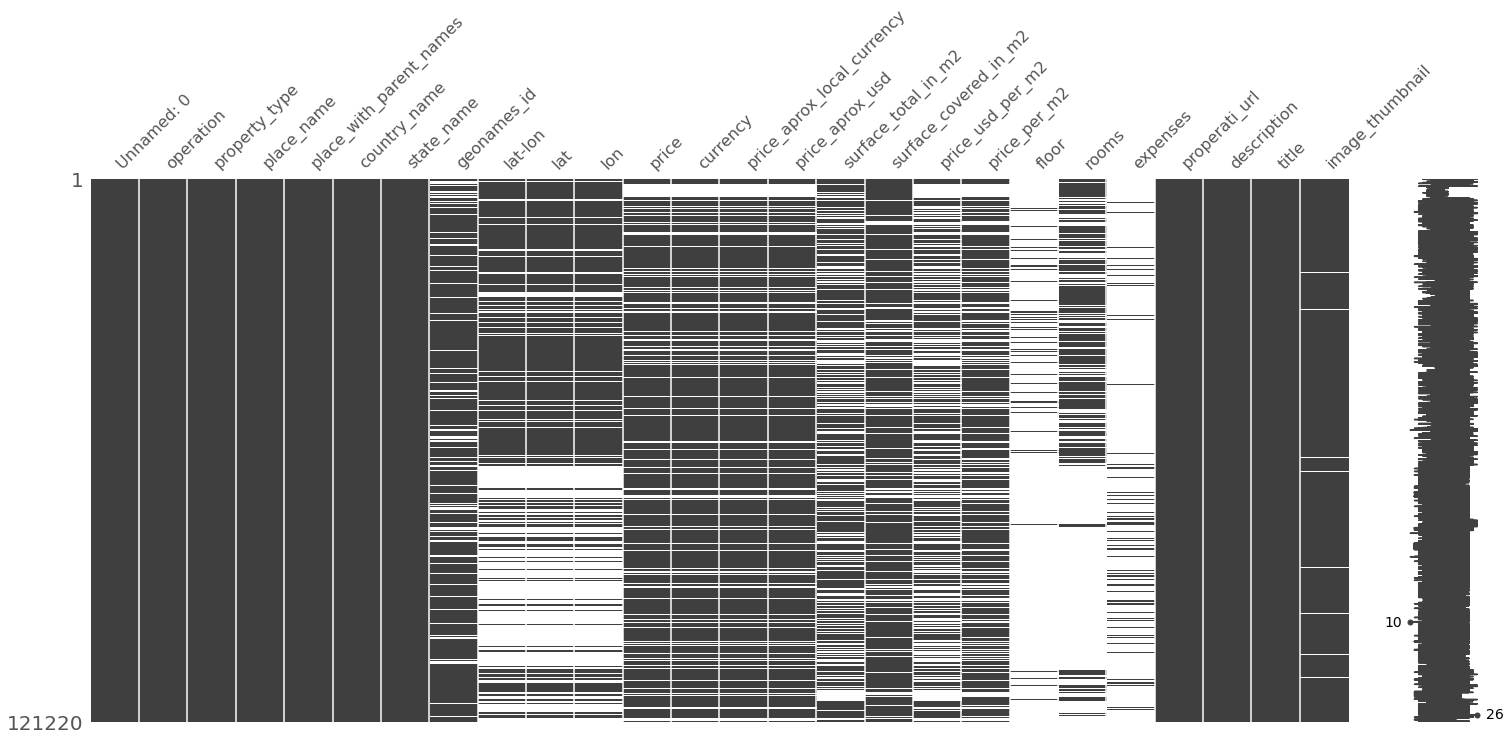

In [394]:
# Ahora aprovechamos la visualización registro a registro que nos proporciona el gráfico de matriz.

msno.matrix(original_data)

## 3. Limpieza de datos.

### 3.1. Eliminación de registros por densidad de la provincia o localidad a la que corresponden.

Atento a que el datset contiene un total de 121.220 registros, analizaremos si es posible descartar, en primer lugar, aquellos que pertenezcan a
provincias o localidades que no tengan un % representativo de instancias dentro del total.
Para esto, haremos uso de la columna 'state_name'.
En primer lugar, mostraremos la densidad de cada estado.

In [395]:
dg = original_data.loc[:, ['state_name', 'lat',"lon"]]
print (dg)

                          state_name    lat    lon
0                    Capital Federal -34.66 -58.51
1             Bs.As. G.B.A. Zona Sur -34.90 -57.96
2                    Capital Federal -34.65 -58.52
3                    Capital Federal -34.65 -58.52
4       Buenos Aires Costa Atlántica -38.00 -57.55
...                              ...    ...    ...
121215               Capital Federal    nan    nan
121216      Bs.As. G.B.A. Zona Norte    nan    nan
121217               Capital Federal -34.57 -58.48
121218  Buenos Aires Costa Atlántica    nan    nan
121219               Capital Federal    nan    nan

[121220 rows x 3 columns]


In [396]:
geodg = gpd.GeoDataFrame(dg, geometry=gpd.points_from_xy(dg.lon, dg.lat))
print (geodg)

                          state_name    lat    lon  \
0                    Capital Federal -34.66 -58.51   
1             Bs.As. G.B.A. Zona Sur -34.90 -57.96   
2                    Capital Federal -34.65 -58.52   
3                    Capital Federal -34.65 -58.52   
4       Buenos Aires Costa Atlántica -38.00 -57.55   
...                              ...    ...    ...   
121215               Capital Federal    nan    nan   
121216      Bs.As. G.B.A. Zona Norte    nan    nan   
121217               Capital Federal -34.57 -58.48   
121218  Buenos Aires Costa Atlántica    nan    nan   
121219               Capital Federal    nan    nan   

                           geometry  
0       POINT (-58.50884 -34.66182)  
1       POINT (-57.96433 -34.90388)  
2       POINT (-58.52298 -34.65226)  
3       POINT (-58.51642 -34.64780)  
4       POINT (-57.54945 -38.00263)  
...                             ...  
121215              POINT (nan nan)  
121216              POINT (nan nan)  
121217  P

In [397]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geoarg = world[world.name=='Argentina']
print (geoarg)

    pop_est      continent       name iso_a3  gdp_md_est  \
9  44293293  South America  Argentina    ARG  879,400.00   

                                            geometry  
9  MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...  


In [398]:
def graficar(p_ciudad, p_pais):
    
    ax = p_pais.plot(figsize=(9,12), color='white', edgecolor='black')

    p_ciudad.plot(ax=ax, color='red', alpha= 0.4)

plt.show()

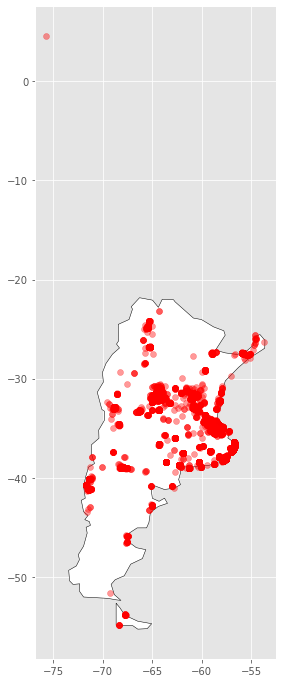

In [399]:
graficar (geodg, geoarg)

Como podemos ver ya a partir de nuestro mapa, la mayor concentración de observaciones se encuentra en la región central del país, especialmente en Buenos Aires, Córdoba y Santa Fe.

A continuación, haremos los cálculos correspondientes para verificar si el gráfico se ajusta a la realidad de nuestro dataset y comenzar con el descarte.

In [400]:
#Mostraremos la cantidad de registros que hay de cada provincia o localidad, en una columna que llamaremos "total".

data_agrupado = original_data.groupby("state_name").size().reset_index(name="Total")
data_agrupado

,state_name,Total
0,Bs.As. G.B.A. Zona Norte,25560
1,Bs.As. G.B.A. Zona Oeste,9322
2,Bs.As. G.B.A. Zona Sur,13952
3,Buenos Aires Costa Atlántica,10006
4,Buenos Aires Interior,2291
5,Capital Federal,32316
6,Catamarca,27
7,Chaco,57
8,Chubut,259
9,Corrientes,583


In [401]:
#Calculamos la frecuencia en proporción al total:

data_por_state = original_data["state_name"]

proportions = 100. * data_por_state.value_counts() / len(data_por_state)
proportions

Capital Federal                26.66
Bs.As. G.B.A. Zona Norte       21.09
Bs.As. G.B.A. Zona Sur         11.51
Córdoba                         9.96
Santa Fe                        8.39
Buenos Aires Costa Atlántica    8.25
Bs.As. G.B.A. Zona Oeste        7.69
Buenos Aires Interior           1.89
Río Negro                       0.67
Neuquén                         0.60
Mendoza                         0.56
Tucumán                         0.56
Corrientes                      0.48
Misiones                        0.38
Entre Ríos                      0.30
Salta                           0.23
Chubut                          0.21
San Luis                        0.21
La Pampa                        0.13
Formosa                         0.05
Chaco                           0.05
San Juan                        0.03
Tierra Del Fuego                0.03
Catamarca                       0.02
Jujuy                           0.02
Santa Cruz                      0.02
Santiago Del Estero             0.00
L

Teniendo en cuenta los resultado obtenidos, hemos decidido conservar únicamente aquellas provincias o localidades que representen más del 7% del total.
Es decir que eliminaremos aquellos registros que no correspondan a Capital Federal o Buenos Aires.

In [402]:
#Armaremos un nuevo dataset, aplicando el filtro recientemente descrito:

freq_mask = proportions > 7
final_states = proportions[freq_mask]

states_list = list(final_states.index)

In [403]:
states_list
print(states_list)

['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Córdoba', 'Santa Fe', 'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Oeste']


In [404]:
mask_1 = original_data["state_name"] == 'Capital Federal'
mask_2 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Norte'
mask_3 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Sur'
mask_4 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Oes'
mask_5 = original_data["state_name"] == 'Buenos Aires Costa Atlántica'
mask_6 = original_data["state_name"] == 'Santa Fe'
mask_7 = original_data["state_name"] == 'Córdoba'

state_mask = mask_1 | mask_2 | mask_3 | mask_4 | mask_5 | mask_6 | mask_7

filtered_data = original_data[state_mask]
filtered_data.sample(5)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
43040,43040,sell,house,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Argentina,Bs.As. G.B.A. Zona Norte,"3,428,983.00","-34.484496,-58.532992",-34.48,...,777.00,nan,"1,930.50",nan,6.00,nan,http://www.properati.com.ar/18xk2_venta_casa_s...,"Venta - Casa - Argentina, Buenos Aires, Zona N...",Casa en Venta ubicado en Lomas San Isidro,https://thumbs4.properati.com/2/IRwU_ftMnLHQmq...
5120,5120,sell,house,Córdoba,|Argentina|Córdoba|Córdoba|,Argentina,Córdoba,"3,860,259.00","-31.2517617664,-64.2704869154",-31.25,...,170.00,343.14,"1,029.41",nan,5.00,nan,http://www.properati.com.ar/15p3v_venta_casa_c...,"HERMOSA CASA EN OBRA, SAN ALFONSO DEL TALAR, 3...","Hermosa casa en obra, SAN ALFONSO DEL TALAR , ...",https://thumbs4.properati.com/1/OoX1ajm8vvAAos...
42013,42013,sell,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,"3,430,863.00","-38.0115285,-57.5454299",-38.01,...,75.00,"2,084.31","2,834.67",nan,3.00,nan,http://www.properati.com.ar/18vio_venta_depart...,"A 6 cuadras de las playas Marplatenses, se pre...",YOUNG TOWER VI CONDOS,https://thumbs4.properati.com/6/lN3M68SCZo9tt8...
46964,46964,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,"3,430,234.00",NaN,nan,...,110.00,"1,346.15","3,181.82",nan,nan,nan,http://www.properati.com.ar/197ae_venta_depart...,ARGAÃARAS 47 Ciudad autonoma de Buenos AiresEn...,"Departamento 260m², Capital Federal, Palermo, ...",https://thumbs4.properati.com/2/pVWhnh9679f5D5...
96147,96147,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,"3,838,574.00",NaN,nan,...,29.00,nan,nan,nan,nan,nan,http://www.properati.com.ar/1bi8l_venta_depart...,"Departamentos Monoambientes, estar comedor con...",Ideal Inversion - Departamento Monoambiente co...,https://thumbs4.properati.com/6/IwPTKMtuuC_-o7...


In [405]:
filtered_data.shape

(104075, 26)

Como vemos a partir del .shape, nuestro nuevo dataset contiene un total de 104075 registros.

Graficaremos a continuación la distribución de densidad de nuestro dataset filtrado.

In [406]:
# Primero, volvemos a calcular las proporciones.

filtered_data_states = filtered_data["state_name"]

filtered_data_proportions = 100. * filtered_data_states.value_counts() / len(filtered_data_states)
filtered_data_proportions


Capital Federal                31.05
Bs.As. G.B.A. Zona Norte       24.56
Bs.As. G.B.A. Zona Sur         13.41
Córdoba                        11.60
Santa Fe                        9.77
Buenos Aires Costa Atlántica    9.61
Name: state_name, dtype: float64

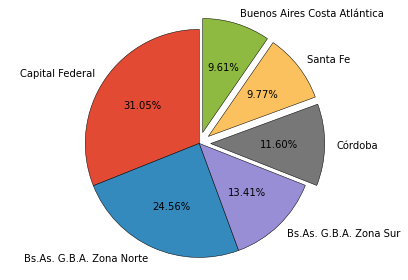

In [407]:

count=filtered_data["state_name"].value_counts().tolist()

label=filtered_data["state_name"].value_counts().index


plt.style.use('ggplot')

dic = dict(zip(label,count))

import itertools
newdic={}
for key, group in itertools.groupby(dic, lambda k: 'Others' if (dic[k]<2500) else k):
     newdic[key] = sum([dic[i] for i in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.2f%%',wedgeprops={"edgecolor":"k"},explode=[0,0,0,0.1,0.1,0.1], startangle=90)
ax.axis('equal')
plt.tight_layout()

plt.show()

Tal como se desprende del gráfico, la mayor cantidad de registros pertenecen a Capital Federal y Bs. As. G.B.A. Zona Norte, siendoque el resto de las localidades representan la mitad o menos de las observaciones de las dos primeras. Por lo cual, haremos una última reducción de nuestro dataset, prescindiendo de aquellas localidades que representan menos del 20% del total. 

In [408]:
#Efectuaremos el último filtro para quedarnos únicamente con registros pertenecientes a Capital Federal y Bs. As. G.B.A. Zona Norte

mask_1 = original_data["state_name"] == 'Capital Federal'
mask_2 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Norte'

state_mask = mask_1 | mask_2

final_filtered_data = original_data[state_mask]

final_filtered_data.sample(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
63690,63690,sell,house,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Argentina,Bs.As. G.B.A. Zona Norte,"3,427,753.00","-34.4779759,-58.5332069",-34.48,...,180.00,"1,890.00","2,100.00",nan,nan,nan,http://www.properati.com.ar/1a98p_venta_casa_t...,MAO. Espectacular casa en el barrio San Marco ...,MAO. Casa de una planta en lote al agua en el ...,https://thumbs4.properati.com/6/Rfg-WHoYOMg1DN...
101493,101493,sell,apartment,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,"3,436,080.00",NaN,nan,...,51.00,nan,"30,088.24",nan,nan,nan,http://www.properati.com.ar/1bpfs_venta_depart...,EDIFICIO CON 35 UNIDADES DE 1 Y 2 AMBIENTES. A...,Departamento en Beccar Alto,https://thumbs4.properati.com/5/DyMV2cCHAezBIz...
43774,43774,sell,apartment,Paternal,|Argentina|Capital Federal|Paternal|,Argentina,Capital Federal,"3,430,087.00","-34.5994894,-58.4681987",-34.60,...,100.00,"1,300.00","1,300.00",nan,4.00,nan,http://www.properati.com.ar/18z3p_venta_depart...,Av. Alvarez Jonte 1.647 /CABA / 4 AMBIENTES CA...,Av. Alvarez Jonte 1.647 /CABA / 4 AMBIENTES CA...,https://thumbs4.properati.com/8/rI3ljU1ch4-okz...
80954,80954,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,"3,430,234.00","-34.5675477151,-58.4323074151",-34.57,...,107.00,"4,545.45","4,672.90",nan,nan,"7,400.00",http://www.properati.com.ar/1axff_venta_depart...,Exclusivo departamento de tres ambientes de 11...,Exclusivo tres ambientes con cochera doble,https://thumbs4.properati.com/0/n07TDGvkmmXgIt...
47574,47574,sell,apartment,San Martín,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,Argentina,Bs.As. G.B.A. Zona Norte,nan,"-34.5896034,-58.5565896",-34.59,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/198ip_venta_depart...,CODIGO: 4008-CARLOSJOSE-9 ubicado en: AV. 1 DE...,DEPARTAMENTO EN VENTA ZONA SAN MARTIN,https://thumbs4.properati.com/6/JkdgHJ7DQnYJlP...


In [409]:
dgcut = final_filtered_data.loc[:, ['state_name', 'lat',"lon"]]

In [410]:
geodgcut = gpd.GeoDataFrame(dgcut, geometry=gpd.points_from_xy(dgcut.lon, dgcut.lat))

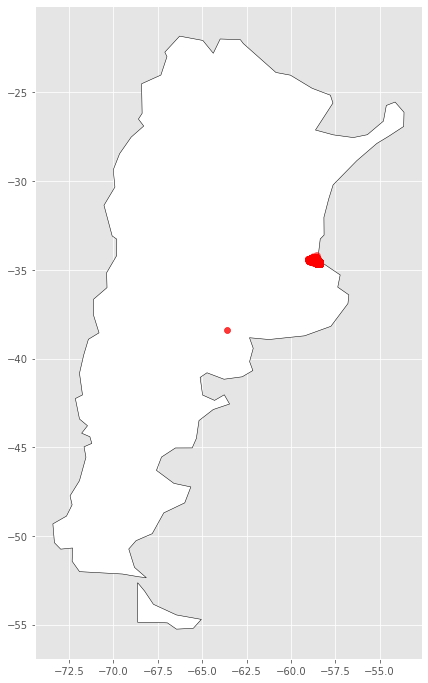

In [411]:
graficar (geodgcut, geoarg)

In [412]:
final_filtered_data_latlon = pd.DataFrame()
final_filtered_data_latlon["localidad"] = final_filtered_data["place_with_parent_names"]
final_filtered_data_latlon["latitud"] = final_filtered_data["lat"]
final_filtered_data_latlon["longitud"] = final_filtered_data["lon"]
final_filtered_data_latlon.dropna()

,localidad,latitud,longitud
0,|Argentina|Capital Federal|Mataderos|,-34.66,-58.51
2,|Argentina|Capital Federal|Mataderos|,-34.65,-58.52
3,|Argentina|Capital Federal|Liniers|,-34.65,-58.52
6,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,-34.53,-58.52
7,|Argentina|Capital Federal|Belgrano|,-34.56,-58.44
...,...,...,...
121153,|Argentina|Capital Federal|Barrio Norte|,-34.60,-58.40
121158,|Argentina|Capital Federal|Recoleta|,-34.59,-58.40
121160,|Argentina|Capital Federal|Belgrano|,-34.56,-58.44
121209,|Argentina|Capital Federal|Belgrano|,-34.56,-58.44


In [413]:
BBox = ((final_filtered_data_latlon.longitud.min(),   final_filtered_data_latlon.longitud.max(),      
         final_filtered_data_latlon.latitud.min(), final_filtered_data_latlon.latitud.max()))
BBox

(-63.616672, -58.3549564938, -38.416097, -34.1598)

In [414]:
ruh_m = plt.imread("Data/map.png")

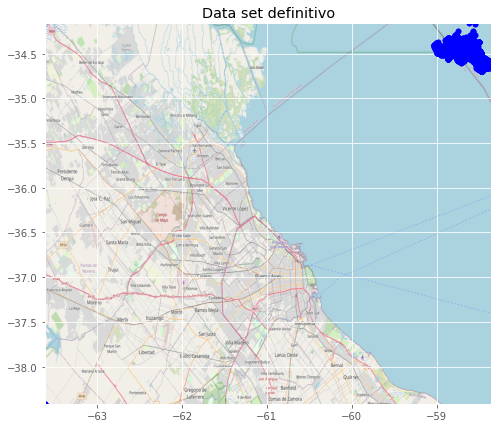

In [415]:
fig, ax = plt.subplots(figsize = (8,7))

ax.set_title('Data set definitivo')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.scatter(final_filtered_data_latlon.longitud, final_filtered_data_latlon.latitud, zorder=1, alpha= 1, c='b', s=30)
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto')

# for i, txt in enumerate(final_filtered_data_latlon.localidad):
#     ax.annotate(txt, (final_filtered_data_latlon.longitud[i],final_filtered_data_latlon.latitud[i]))

### 3.2. Eliminación de registros duplicados.

In [416]:
#Calculamos el total de registros de nuestro nuevo dataset.

len(final_filtered_data)

57876

In [417]:
#Eliminamos los registros duplicados.

final_filtered_data = final_filtered_data.drop_duplicates()
len(final_filtered_data)

57876

Como vemos, el total de registros del dataset antes y después de la eliminación de duplicados es igual, por lo cual no existían duplicados.

In [418]:
# Ahora eliminaremos los registros que tengan valores duplicados en los campos descripción y precio.

final_filtered_data = final_filtered_data.drop_duplicates(subset=['price','description'])
len(final_filtered_data)

53264

En este caso podemos ver que efectivamente había registros con los mismos valores en descripción y precio, y al haberlos eliminado redujimos el dataset en poco más de cuatro mil unidades.

### 3.3. Eliminación de columnas innecesarias.

In [419]:
final_filtered_data.drop(['operation', 'Unnamed: 0', 'country_name', 'floor', 'expenses', 'image_thumbnail'], axis=1, inplace=True)

### 3.4. Cálculo de columnas con gran porcentaje de valores NaN.

In [420]:
#Calculamos porcentaje de nulos de cada columna.

final_filtered_data_nulls = get_null(final_filtered_data)
final_filtered_data_nulls

property_type                 0.00
place_name                    0.04
place_with_parent_names       0.00
state_name                    0.00
geonames_id                  19.69
lat-lon                      39.08
lat                          39.08
lon                          39.08
price                         5.53
currency                      5.53
price_aprox_local_currency    5.53
price_aprox_usd               5.53
surface_total_in_m2          23.08
surface_covered_in_m2         6.64
price_usd_per_m2             28.07
price_per_m2                 11.42
rooms                        61.45
properati_url                 0.00
description                   0.00
title                         0.00
dtype: float64

## 4. Imputación de valores faltantes.

In [421]:
# Obtenemos los valores faltantes por columna.
final_filtered_data_missing_values = final_filtered_data.isnull().sum()

missing_values_count

property_type                     0
place_name                       23
place_with_parent_names           0
state_name                        0
geonames_id                   10486
lat-lon                       20813
lat                           20813
lon                           20813
price                          2948
currency                       2948
price_aprox_local_currency     2948
price_aprox_usd                2948
surface_total_in_m2           12293
surface_covered_in_m2          3535
price_usd_per_m2              14949
price_per_m2                   6085
rooms                         32732
properati_url                     0
description                       1
title                             0
dtype: int64

In [422]:
# how many total missing values do we have?
total_cells = np.product(final_filtered_data.shape)
total_missing = final_filtered_data_missing_values.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

14.487740312406128


In [423]:
# auto complete data, the column place_name can complete with the column place_with_parent_name
# remove all columns with at least one missing value
columns_with_na_dropped = final_filtered_data.dropna(axis=1)
columns_with_na_dropped.head()

,property_type,place_with_parent_names,state_name,properati_url,title
0,PH,|Argentina|Capital Federal|Mataderos|,Capital Federal,http://www.properati.com.ar/15bo8_venta_ph_mat...,2 AMB TIPO CASA SIN EXPENSAS EN PB
2,apartment,|Argentina|Capital Federal|Mataderos|,Capital Federal,http://www.properati.com.ar/15bod_venta_depart...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,PH,|Argentina|Capital Federal|Liniers|,Capital Federal,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 amb. cfte. reciclado
6,PH,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,http://www.properati.com.ar/15bor_venta_ph_mun...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,..."
7,apartment,|Argentina|Capital Federal|Belgrano|,Capital Federal,http://www.properati.com.ar/15bot_venta_depart...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...


In [424]:
# just how much data did we lose? example to remove null fields
print("Columns in original dataset: %d \n" % final_filtered_data.shape[1])
print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Columns in original dataset: 20 

Columns with na's dropped: 5


In [425]:
#Split the column for fill others fields
s = final_filtered_data['place_with_parent_names'].str.split("|", n=4, expand=True)

In [426]:
s.head()

,0,1,2,3,4
0,,Argentina,Capital Federal,Mataderos,
2,,Argentina,Capital Federal,Mataderos,
3,,Argentina,Capital Federal,Liniers,
6,,Argentina,Bs.As. G.B.A. Zona Norte,Vicente López,Munro|
7,,Argentina,Capital Federal,Belgrano,


In [427]:
url = final_filtered_data['properati_url'].str.split(r"\_|-", n=25, expand=True)

In [428]:
url.head(5)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,http://www.properati.com.ar/15bo8,venta,ph,mataderos,lavadero,patio,inmobiliaria,fedele,None,None,...,None,None,None,None,None,None,None,None,None,None
2,http://www.properati.com.ar/15bod,venta,departamentos,mataderos,lavadero,placard,inmobiliaria,fedele,None,None,...,None,None,None,None,None,None,None,None,None,None
3,http://www.properati.com.ar/15boh,venta,ph,liniers,patio,g,goffredo,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,http://www.properati.com.ar/15bor,venta,ph,munro,lavadero,patio,garage,alejandra,maradona,inmobiliaria,...,None,None,None,None,None,None,None,None,None,None
7,http://www.properati.com.ar/15bot,venta,departamentos,belgrano,lavadero,piscina,luminoso,estrenar,estilo,inmobiliario,...,None,None,None,None,None,None,None,None,None,None


In [429]:
final_filtered_data = final_filtered_data.fillna("")
final_filtered_data = final_filtered_data[final_filtered_data['properati_url'].str.contains(r'^(?=.*gimnasio)(?=.*balcon)', flags=re.IGNORECASE, regex=True)]

In [430]:
suma = np.product(final_filtered_data.shape)

In [431]:
print(suma)

70120


In [432]:
final_filtered_data.head()

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,properati_url,description,title
50,apartment,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Bs.As. G.B.A. Zona Norte,"3,428,983.00","-34.4825362878,-58.5878735289",-34.48,-58.59,"440,000.00",USD,"7,763,580.00","440,000.00",142.00,122.00,"3,098.59","3,606.56",4.00,http://www.properati.com.ar/15bud_venta_depart...,Departamento a estrenar en ARBORIS La Horqueta...,Excelente departamento a estrenar en Arboris L...
147,apartment,Benavidez,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Bena...,Bs.As. G.B.A. Zona Norte,"3,436,048.00","-34.40083,-58.677943",-34.40,-58.68,"185,000.00",USD,"3,264,232.50","185,000.00",,100.00,,"1,850.00",3.00,http://www.properati.com.ar/15d8c_venta_depart...,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,"Departamento 2 dormitorios, 2 baños, parrilla."
219,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,"3,436,077.00","-34.565318066,-58.4417518602",-34.57,-58.44,"1,100,000.00",USD,"19,408,950.00","1,100,000.00",310.00,300.00,"3,548.39","3,666.67",6.00,http://www.properati.com.ar/15dj3_venta_depart...,Piso en Belgrano entre Villanueva y Luis ...,Impecable planta 5 Ambientes en La Mejor Zona...
244,apartment,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Capital Federal,"3,429,760.00","-34.6114635369,-58.3627451275",-34.61,-58.36,"550,000.00",USD,"9,704,475.00","550,000.00",109.00,99.00,"5,045.87","5,555.56",4.00,http://www.properati.com.ar/15dnw_venta_depart...,- Departamento de 4 ambientes- Pasante- Cocher...,Departamento de 4 ambientes con cochera
252,apartment,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Capital Federal,"3,429,760.00","-34.6194333916,-58.3613734778",-34.62,-58.36,"1,195,000.00",USD,"21,085,177.50","1,195,000.00",198.00,185.00,"6,035.35","6,459.46",4.00,http://www.properati.com.ar/15doj_venta_depart...,MADERO HARBOUR HOUSE. ESPECTACULAR DEPARTAMENT...,MADERO HARBOUR HOUSE


In [433]:
url.drop([0, 1, 2, 3], axis=1, inplace=True)

In [434]:
url.head()

,4,5,6,7,8,9,10,11,12,13,...,16,17,18,19,20,21,22,23,24,25
0,lavadero,patio,inmobiliaria,fedele,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,lavadero,placard,inmobiliaria,fedele,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,patio,g,goffredo,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,lavadero,patio,garage,alejandra,maradona,inmobiliaria,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,lavadero,piscina,luminoso,estrenar,estilo,inmobiliario,dl8,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [435]:
final_filtered_data.isna().sum()

property_type                 0
place_name                    0
place_with_parent_names       0
state_name                    0
geonames_id                   0
lat-lon                       0
lat                           0
lon                           0
price                         0
currency                      0
price_aprox_local_currency    0
price_aprox_usd               0
surface_total_in_m2           0
surface_covered_in_m2         0
price_usd_per_m2              0
price_per_m2                  0
rooms                         0
properati_url                 0
description                   0
title                         0
dtype: int64

In [436]:
final_filtered_data.replace('NAN', np.NaN, inplace=True)

In [437]:
final_filtered_data.isna().sum()

property_type                 0
place_name                    0
place_with_parent_names       0
state_name                    0
geonames_id                   0
lat-lon                       0
lat                           0
lon                           0
price                         0
currency                      0
price_aprox_local_currency    0
price_aprox_usd               0
surface_total_in_m2           0
surface_covered_in_m2         0
price_usd_per_m2              0
price_per_m2                  0
rooms                         0
properati_url                 0
description                   0
title                         0
dtype: int64

In [438]:
(final_filtered_data.isnull().sum() / len(final_filtered_data)*100)

property_type                0.00
place_name                   0.00
place_with_parent_names      0.00
state_name                   0.00
geonames_id                  0.00
lat-lon                      0.00
lat                          0.00
lon                          0.00
price                        0.00
currency                     0.00
price_aprox_local_currency   0.00
price_aprox_usd              0.00
surface_total_in_m2          0.00
surface_covered_in_m2        0.00
price_usd_per_m2             0.00
price_per_m2                 0.00
rooms                        0.00
properati_url                0.00
description                  0.00
title                        0.00
dtype: float64

In [439]:
final_filtered_data.rooms[~final_filtered_data.rooms.isnull()]

50       4.00
147      3.00
219      6.00
244      4.00
252      4.00
         ... 
121093       
121120       
121138       
121148       
121213       
Name: rooms, Length: 3506, dtype: object

In [440]:
final_filtered_data.rooms.isnull().sum() * 100 / len(final_filtered_data)

0.0

In [441]:
#\d= any number (a digit)
#\d represents a digit.Ex: \d{1,5} it will declare digit between 1,5 like 424,444,545 etc.
#\n = new line
#. + * ? [] $ ^ () {} | \
var = ["cua", "amb"]
patron = r"(\d " + var[1] + ")"
regex = re.compile(patron)
description_series = final_filtered_data['description'].str.lower()
description_series = description_series.apply(lambda x: str(x))
resultado_ambientes = description_series.apply(lambda x: regex.findall(x))

In [442]:
resultado_ambientes

50             []
147            []
219            []
244       [4 amb]
252            []
           ...   
121093         []
121120    [2 amb]
121138    [2 amb]
121148         []
121213         []
Name: description, Length: 3506, dtype: object

In [443]:
len([i for i in resultado_ambientes if i])

2074

In [444]:
resultado_ambientes = resultado_ambientes.apply(lambda x: x[0] if len(x) != 0 else np.NaN )
resultado_ambientes = resultado_ambientes.str.split('amb')

In [445]:
resultado_ambientes = resultado_ambientes.apply(lambda x: x[0] if x is not np.NaN else np.NaN )

In [446]:
resultado_ambientes

50        NaN
147       NaN
219       NaN
244        4 
252       NaN
         ... 
121093    NaN
121120     2 
121138     2 
121148    NaN
121213    NaN
Name: description, Length: 3506, dtype: object

In [447]:
final_filtered_data['ambientes'] = resultado_ambientes

In [448]:
final_filtered_data.ambientes

50        NaN
147       NaN
219       NaN
244        4 
252       NaN
         ... 
121093    NaN
121120     2 
121138     2 
121148    NaN
121213    NaN
Name: ambientes, Length: 3506, dtype: object

In [449]:
# Completamos los registros faltantes de rooms con los datos extraídos de la descripción
final_filtered_data['rooms'] = final_filtered_data['rooms'].fillna(final_filtered_data['ambientes'])

In [450]:
final_filtered_data.rooms

50       4.00
147      3.00
219      6.00
244      4.00
252      4.00
         ... 
121093       
121120       
121138       
121148       
121213       
Name: rooms, Length: 3506, dtype: object

In [451]:
# Bajamos de 66% a 45% de datos faltantes
final_filtered_data.rooms.isnull().sum()*100 /len(final_filtered_data)

0.0

In [452]:
patron_price = "(dls|usd|ars|\$)\s?(\d{5,8})|(\d{5,8})\s?(dls|usd|ars|\$)"
regex_price = re.compile(patron_price)
description_series = final_filtered_data['description'].str.lower()
description_series = description_series.apply(lambda x: str(x))
resultado_price = description_series.apply(lambda x: regex_price.findall(x))

In [453]:
resultado_price.sample(15)

112640    []
110334    []
91066     []
28331     []
50502     []
107118    []
101213    []
60663     []
54344     []
15248     []
108435    []
5973      []
5960      []
95937     []
107110    []
Name: description, dtype: object

In [454]:
no_vacias = [i for i in resultado_price if i]
no_vacias[0:10]

[[('usd', '95000', '', '')],
 [('usd', '181000', '', '')],
 [('usd', '190000', '', '')],
 [('usd', '40000', '', '')],
 [('usd', '40000', '', '')],
 [('usd', '40000', '', '')],
 [('usd', '40000', '', '')],
 [('usd', '40000', '', '')],
 [('usd', '145000', '', '')],
 [('usd', '640000', '', '')]]

In [455]:
precio_2 = resultado_price.apply(lambda x: x[0][1] if ((len(x) != 0)) else np.NaN )
precio_2.to_csv('precio.csv', encoding='utf-8')

In [456]:
precio_1 = resultado_price.apply(lambda x: x[0][0] if ((len(x) != 0)) else np.NaN )
precio_1.iloc[270]

nan

In [457]:
final_filtered_data['precio_relleno'] = precio_2
final_filtered_data['precio_relleno_mon'] = precio_1
final_filtered_data.sample(5)

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,properati_url,description,title,ambientes,precio_relleno,precio_relleno_mon
7697,apartment,Caballito,|Argentina|Capital Federal|Caballito|,Capital Federal,"3,435,874.00","-34.6036844,-58.3815591",-34.60,-58.38,"310,000.00",USD,...,72.00,"4,025.97","4,305.56",3.00,http://www.properati.com.ar/15yt1_venta_depart...,DEPARTAMENTO TRES AMBIENTES A ESTRENAR .FRENTE...,DEPARTAMENTO EN VENTA,NaN,NaN,NaN
97040,apartment,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,"3,436,080.00",,,,"139,000.00",USD,...,50.00,"2,780.00","2,780.00",,http://www.properati.com.ar/1bji3_venta_depart...,Departamento 2 ambientes en torre con excelent...,Departamento 2 ambientes con balcon y cochera ...,2,NaN,NaN
46318,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Tigre|,Bs.As. G.B.A. Zona Norte,,"-34.4303409,-58.5711787",-34.43,-58.57,"125,200.00",USD,...,60.00,"2,019.35","2,086.67",2.00,http://www.properati.com.ar/195wd_venta_depart...,"VENTA DESDE POZO!!! PROYECTO ""EDIFICIO TIGRE V...",Cazón al 500 1° D VENTA DESDE POZO! PROYECTO,NaN,NaN,NaN
7614,house,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,"3,428,983.00","-34.478746,-58.553091",-34.48,-58.55,"980,000.00",USD,...,689.00,,"1,422.35",6.00,http://www.properati.com.ar/15yfm_venta_casa_s...,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,EXCELENTE RESIDENCIA EN LOMAS DE SAN ISIDRO,NaN,NaN,NaN
78353,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Bs.As. G.B.A. Zona Norte,,,,,"3,732,559.00",ARS,...,69.00,"1,730.05","54,095.06",,http://www.properati.com.ar/1au1c_venta_depart...,Departamento de 2 ambientes con Jardin y vista...,Venta en Pozo Acqua Rio Nordelta,2,NaN,NaN


In [458]:
len(final_filtered_data) - final_filtered_data.precio_relleno.isnull().sum()

64

In [459]:
final_filtered_data['precio'] = final_filtered_data['price_aprox_usd'].fillna(final_filtered_data['precio_relleno'])

In [460]:
final_filtered_data.precio.isnull().sum() *100 / len(final_filtered_data)

0.0

In [461]:
(~final_filtered_data.precio_relleno.isnull()).sum()

64

In [462]:
final_filtered_data.isna().sum()

property_type                    0
place_name                       0
place_with_parent_names          0
state_name                       0
geonames_id                      0
lat-lon                          0
lat                              0
lon                              0
price                            0
currency                         0
price_aprox_local_currency       0
price_aprox_usd                  0
surface_total_in_m2              0
surface_covered_in_m2            0
price_usd_per_m2                 0
price_per_m2                     0
rooms                            0
properati_url                    0
description                      0
title                            0
ambientes                     1432
precio_relleno                3442
precio_relleno_mon            3442
precio                           0
dtype: int64

In [463]:
#superficie en descripción
patron_sup = "((\d{1,3})\s?(m2)|(\d{1,3})\s?(metros))"
regex_sup = re.compile(patron_sup)
description_series = final_filtered_data['description'].str.lower()
description_series = description_series.apply(lambda x: str(x))
resultado_sup = description_series.apply(lambda x: regex_sup.findall(x))

In [464]:
resultado_sup.head(20)

50                                                    []
147                                                   []
219                                                   []
244                                                   []
252                                                   []
270                                [(50 m2, 50, m2, , )]
271                                [(88 m2, 88, m2, , )]
415    [(120m2, 120, m2, , ), (6 metros, , , 6, metro...
456                                [(16 m2, 16, m2, , )]
457                                                   []
459                                                   []
464                                                   []
563                                                   []
565    [(8 m2, 8, m2, , ), (15 m2, 15, m2, , ), (104 ...
572                                                   []
589                                                   []
619                                                   []
622                            

In [465]:
sup1 = resultado_sup.apply(lambda x: x[0][1] if ((len(x) != 0)) else np.NaN )

In [466]:
final_filtered_data.description.iloc[6]

'CODIGO:  ubicado en: Ricardo Balbin DR. 4300 -  Publicado por: LA KASA FELIZ PROP. Y SERVICIOS. El precio es de USD 181000 null. Descripción  A ESTRENAR - POSESION y ESCRITURA DENTRO DE LOS 60 DIAS DEPARTAMENTO AL CONTRAFRENTE - SUPERFICIE TOTAL: 71,88 m2. - DE 3 AMBIENTES: LIVING-COMNEDOR: 7,60X3 CON SALIDA A BALCON  2 DORMITORIOS CON PLACARDS CON FRENTE ESPEJADO y CON INTERIORES COMPLETOS: (3,10X2,70 CON SALIDA A BALCON) (3,04X2,80) 1 BAÑO TOIILETTE COCINA CON LAVADERO INCORPORADO. CALEFACCION POR LOZA RADIANTE INDIVIDUAL POR CABLE, MARCA EUROCABLE, TERMOSTATO POR AMBIENTE. AGUA CALIENTE CENTRAL. PREINSTALACION ELECTRICA PARA EQUIPOS TIPO SPLITS . INSTALACION DE TELEFONICA: LAS UNIDADES SE ENTREGAN CABLEADAS HASTA LA PRIMER BOCA y CUENTAN CON CANALIZACIONES VACIAS. CANALIZACIONES y BOCAS VACIAS PARA CONEXION DE TV DETALLES DEL EDIFICIO: HALL CON MARMOL y REVESTIMIENTO EN WENGUE. 2 ASCENSORES DE PRIMERA MARCA (UNO PARA 14 PERSONAS). AGUA CALIENTE CENTRAL, CON TRES TERMOTANQUES MARCA 

In [467]:
type(sup1)

pandas.core.series.Series

In [468]:
#https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/
#https://www.guru99.com/python-regular-expressions-complete-tutorial.html
#https://docs.python.org/3/library/re.html
#https://towardsdatascience.com/how-to-export-pandas-dataframe-to-csv-2038e43d9c03

## 5. Visualizaciones finales.

## 6. Dataset final.

In [469]:
# dataset.describe

In [470]:
# dataset.columns

In [471]:
# dataset.shape

In [472]:
# dataset_nulls = get_null(dataset)

In [473]:
# plt.figure(figsize=(10,6))
# sns.displot(
#     data=df.isna().melt(value_name="missing"),
#     y="variable",
#     hue="missing",
#     multiple="fill",
#     aspect=1.25)

In [474]:
# dataset.dropna(inplace=True)

In [475]:
#sns.pairplot(df,vars=['price_aprox_usd', 'distance_obelisco', 'surface_covered_in_m2'],corner=True, dropna=True)

In [476]:
# fig, axs = plt.subplots(1,3, figsize=(15, 5))

# sns.scatterplot(x=((df[(df.property_type == 'apartment')].price_aprox_usd).apply(custom_log10)), 
#                 y=(df[(df.property_type == 'apartment')].surface_covered_in_m2 ), 
#                 alpha=0.2, ax=axs[0], hue=df['segmento_precio_m2'])

# axs[0].set_xlabel('log (Price USD)')
# axs[0].set_title("Departamentos")

# sns.scatterplot(x=((df[(df.property_type == 'house')].price_aprox_usd).apply(custom_log10)), 
#                 y=(df[(df.property_type == 'house')].surface_covered_in_m2 ), 
#                 alpha=0.2, ax=axs[1], hue=df['segmento_precio_m2'])

# axs[1].set_xlabel('log (Price USD)')
# axs[1].set_title("Casas")

# sns.scatterplot(x=((df[(df.property_type == 'store')].price_aprox_usd).apply(custom_log10)), 
#                 y=(df[(df.property_type == 'store')].surface_covered_in_m2 ), 
#                 alpha=0.2, ax=axs[2], hue=df['segmento_precio_m2'])

# axs[2].set_xlabel('log (Price USD)')
# axs[2].set_title("Comercial")

In [477]:
# fig, axs = plt.subplots(1,3, figsize=(15, 5))

# sns.scatterplot(x=((df[(df.property_type == 'apartment')].price_aprox_usd)), 
#                 y=(df[(df.property_type == 'apartment')].surface_covered_in_m2 ), 
#                 alpha=0.2, ax=axs[0], hue=df['segmento_precio_m2'])


# axs[0].set_title("Departamentos")

# sns.scatterplot(x=((df[(df.property_type == 'house')].price_aprox_usd)), 
#                 y=(df[(df.property_type == 'house')].surface_covered_in_m2 ), 
#                 alpha=0.2, ax=axs[1], hue=df['segmento_precio_m2'])


# axs[1].set_title("Casas")

# sns.scatterplot(x=((df[(df.property_type == 'store')].price_aprox_usd)), 
#                 y=(df[(df.property_type == 'store')].surface_covered_in_m2 ), 
#                 alpha=0.2, ax=axs[2], hue=df['segmento_precio_m2'])


# axs[2].set_title("Comercial")

In [478]:
# En primer lugar, vamos a seleccionar la información que creemos será de utilidad para cumplir con el objetivo.

# Características del bien que pueden permitirnos aproximar el precio de una propiedad: 

#     1) Localidad (place_with_parent_names) 
#     2) Tipo de propiedad (property_type)
#     3) Superficie(m2), cubierta y total (surface_total_in_m2, surface_covered_in_m2)
#     4) Ambientes (rooms)

# Como referencia para poder predecir precios, tomaremos los que se listan en el data set (price, currency, price_aprox_usd), 
# siempre buscando agrupar los mismos por las características que detallamos previamente.

#Características que van a permitirnos agregar más información sobre el bien en cuestión y su precio:

#     5) Ubicación geográfica (place_with_parent_names, lat-lon)
#     6) Amenities (properati_url, description, title)

In [479]:
#En segundo lugar, teniendo en cuenta que el data set contiene muchísima información y no toda estará completa o será de utilidad a
#nuestro entender, haremos un proceso inicial de limpieza y corrección, intentando recuperar información a partir de otras variables.

#a) Estandarizar los precios a una moneda. En nuestro caso, decidimos unificar los valores en USD.

# b) Completaremos datos faltantes de las columnas que consideramos relevantes, aprovechando la información descriptiva de las columnas title, 
# descriprion y url. Para ello recurriremos a las expresiones regulares para completar las columnas de precios, superficie total
# (surface_total_in_m2), habitaciones (rooms) y precios por m2.


In [480]:
#En tercer lugar, seleccionaremos aquellas variables que consideramos más importantes en relación a nuestro objetivo para efectuar
#un análisis descriptivo de las mismas.

In [481]:
#En cuarto lugar, haremos las visualizaciones generando distintos gráficos representativos de los resultados obtenidos.

In [482]:
#Por último, crearemos nuevas columnas a partir de las características dadas que puedan tener valor predictivo.